<!-- TITLE: Extracellular potentials from neuron simulation -->
<!-- AUTHOR: Solveig Naess -->
<!--  -->
<!-- DATE: today -->

<!-- TOC: on -->



<!-- --- begin exercise --- -->

## Exercise 1: Record extracellular potential from passive cell


**a)**
**Equation for extracellular potential**
* Describe all the symbols going into the equation for the extracellular potential from a multicompartmental neuron model:

$\Phi(\mathbf{r}, t)  = \frac{1}{4 \pi \sigma} \sum_{n=1}^N \frac{I_n(t)}{|\mathbf{r} - \mathbf{r_n}|}$

Discuss the following with a fellow student:
* What is the unit of $\Phi$ when $[\sigma] = S/m, [I] = nA$ and $[r] = \mu m$?

* Why cannot point-neuron models (alone) be used to compute extracellular potentials?

* What is the simplest neuron model that can be used for computing extracellular potentials?
<!-- !bsol -->
<!-- <linebreak> $[\Phi] = mV$ -->
<!-- <linebreak> Current sources in the brain must always sum to zero. -->
<!-- <linebreak> A two-compartment neuron model. -->
<!-- !esol -->

**b)**
**Record extracellular potential with grid electrode from passive cell**
<linebreak> In this example we want to record the extracellular potentials from a passive cell
with a virtual grid electrode. Run the code-cells below to simulate a passive neuron and plot the extracellular potentials.

In [1]:
%matplotlib inline

import LFPy
import numpy as np
from pylab import *
from matplotlib.collections import PolyCollection
from ipywidgets import widgets, fixed
from neuron import h

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def extracellular_potential(morphology,
                            synapse_xpos,
                            synapse_zpos,
                            sigma,
                            syn_weight,
                            rot):
    cell_parameters = {
        'morphology' : morphology, # from Mainen & Sejnowski, J Comput Neurosci, 1996
        'cm' : 1.0,         # membrane capacitance
        'Ra' : 150.,        # axial resistance
        'v_init' : -65.,    # initial crossmembrane potential
        'passive' : True,   # turn on NEURONs passive mechanism for all sections
        'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65},
        'dt' : 2.**-3,      # simulation time step size
        'tstart' : 0.,      # start time of simulation, recorders start at t=0
        'tstop' : 100.,     # stop simulation at 100 ms.
    }


    cell = LFPy.Cell(**cell_parameters)
    cell.set_rotation(x=rot[0], y=rot[1], z=rot[2])


    synapse_parameters = {
        'idx' : cell.get_closest_idx(x=synapse_xpos, y=0., z=synapse_zpos),
        'e' : 0.,                   # reversal potential
        'syntype' : 'ExpSyn',       # synapse type
        'tau' : 5.,                 # synaptic time constant
        'weight' : syn_weight,            # synaptic weight
        'record_current' : True,    # record synapse current
    }

    # Create synapse and set time of synaptic input
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(np.array([20.]))

    # simulate cell
    cell.simulate(rec_imem=True, rec_vmem=True)

    # Create a grid of measurement locations, in (mum)
    X, Z = np.mgrid[-700:701:50, -400:1201:50]
    Y = np.zeros(X.shape)
    # set electrode parameters
    grid_electrode_parameters = {
        'sigma' : sigma,      # extracellular conductivity
        'x' : X.flatten(),  # electrode requires 1d vector of positions
        'y' : Y.flatten(),
        'z' : Z.flatten()
    }

    grid_electrode = LFPy.RecExtElectrode(cell,**grid_electrode_parameters)
    # compute extracellular potentials
    grid_electrode.calc_lfp()
    LFP = grid_electrode.LFP

    # plot LFP and neuron morphology at time = time_step
    time_step = np.argmax(np.abs(np.sum(LFP, axis=0)))
    fig = figure()
    ax = fig.add_axes([.1,.1,.8,.8], aspect='equal', frameon=False)
    cax = fig.add_axes([0.85, 0.1, 0.02, 0.8], frameon=False)

    LFP_measurements = LFP[:,time_step].reshape(X.shape)
    max_LFP = 1e-3#np.max(np.abs(LFP_measurements))
    LFP_norm = LFP_measurements/max_LFP
    num = 9
    levels = np.logspace(-4, 0, num = num)
    levels_norm = np.concatenate((-levels[::-1], levels))
    rainbow_cmap = cm.get_cmap('PRGn') # rainbow, spectral, RdYlBu
    colors_from_map = [rainbow_cmap(i*np.int(255/(len(levels_norm) - 2))) for i in range(len(levels_norm) -1)]
    colors_from_map[num - 1] = (1.0, 1.0, 1.0, 1.0)
    ticks = [levels_norm[2*i] for i in range(int(num/2) + 1)] + [levels_norm[num + 2*i] for i in range(int(num/2) + 1)]

    ep_intervals = ax.contourf(X, Z, LFP_norm,# vmin=-200, vmax=200,
                               zorder=-2, colors = colors_from_map,
                               levels=levels_norm, extend = 'both') #norm = LogNorm())#,
                                          # norm = SymLogNorm(1E-30))#, vmin = -40, vmax = 40))

    ax.contour(X, Z, LFP_norm, lw = 0.4,  # 20,
               colors='k', zorder = -2,  # extend='both')
               levels=levels_norm)
    cbar = fig.colorbar(ep_intervals, cax=cax)
    cbar.set_label('$\Phi(\mathbf{r}, t_{max}) [\mu V]$', fontsize='xx-large')
    cbar.outline.set_visible(False)
    cbar.set_ticks(ticks)

    #plot morphology
    zips = []
    for x, z in cell.get_idx_polygons():
        zips.append(list(zip(x, z)))
    polycol = PolyCollection(zips,
                             edgecolors='none',
                             facecolors='k')
    ax.add_collection(polycol)
    ax.plot(cell.xmid[cell.synidx], cell.zmid[cell.synidx], 'ro', ms = 5.)
    show()

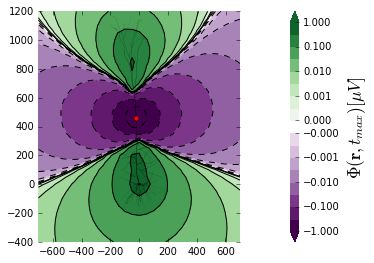

In [4]:
#morphology = './cells/j4a.hoc'
morphology = './cells/cell1.asc'
#rotation = [4.99, -4.33, 3.14]
rotation = [np.pi/2, 0,0]
slider = widgets.interact(extracellular_potential, morphology=fixed(morphology),
                          synapse_xpos=widgets.IntSlider(min=-200,max=200,step=10.,value=-200),
                          synapse_zpos=widgets.IntSlider(min=-200,max=1400,step=10,value=800),
                          syn_weight=widgets.FloatSlider(min=0.,max=.1,step=.0001,value=0.001),
                          sigma=widgets.FloatSlider(min=0.0,max=1.5,step=.1,value=0.3),
                          rot = fixed(rotation),
                          )

**c)**
**Medium conductivity**
* How will changing the extracellular conductivity affect the extracellular potential? Discuss with a fellow student.

* Alter the sigma and rerun the code.

**d)**
**Synapse location and extracellular potential**
* Discuss the sign and shape of the extracellular potential with a fellow student. Which parts of the neuron can be recognized as current sinks, and which can be recognized as and current sources?

* Can you tell from the plot whether the synapse is excitatory or inhibitory?

* Change the synapse weight and location. How does this change the shape of the extracellular potential?

**e)**
Try changing your morphology to the Hay pyramidal cell.

<!-- --- end exercise --- -->